# Sequence Models

Using data from yahoo finance, create a RNN, LSTM, and GRU to give predicitons of closing prices for Nividia stock.

Compare each model with each other to see which does better in making predictions. 

Build a multi-variable LSTM with the same Nividia stock data from yahoo finance and see how well it performs.

In [1]:
import yfinance as yf

nvidia_data = yf.Ticker("NVDA")

In [2]:
nvidia_price_df = nvidia_data.history(period='max')[['Close']]

In [3]:
nvidia_price_df

,Close
Date,
1999-01-22 00:00:00-05:00,0.037605
1999-01-25 00:00:00-05:00,0.041545
1999-01-26 00:00:00-05:00,0.038321
1999-01-27 00:00:00-05:00,0.038202
1999-01-28 00:00:00-05:00,0.038082
...,...
2025-12-01 00:00:00-05:00,179.909988
2025-12-02 00:00:00-05:00,181.449905
2025-12-03 00:00:00-05:00,179.580002


In [4]:
import pandas as pd
nvidia_price_df.to_csv('data/nvidia_stock_price_max_hist.csv')

In [5]:
nvidia_price_df.describe()

,Close
count,6761.000000
mean,13.141670
std,34.654923
min,0.031278
25%,0.262215
50%,0.447219
75%,5.475042
max,207.028473


In [6]:
nvidia_close = nvidia_price_df[['Close']]

array([[<Axes: title={'center': 'Close'}>]], dtype=object)

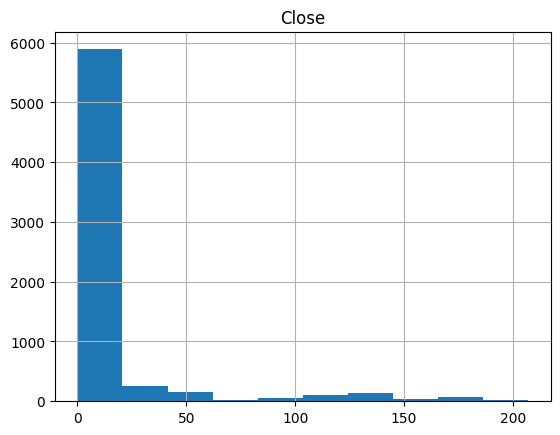

In [7]:
import matplotlib.pyplot as plt
nvidia_close.hist()

<Axes: xlabel='Date'>

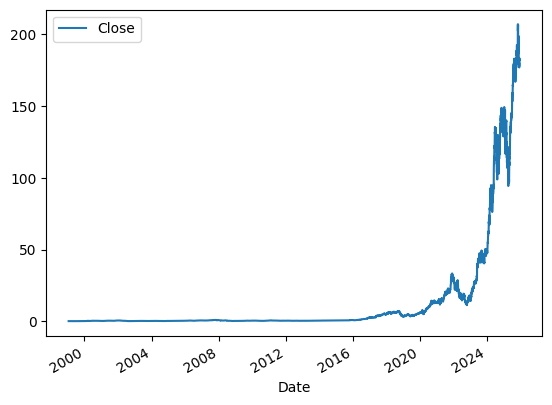

In [8]:
nvidia_close.plot()

In [9]:
nvidia_close_norm = (nvidia_close - nvidia_close.min()) / (nvidia_close.max() - nvidia_close.min())

<Axes: xlabel='Date'>

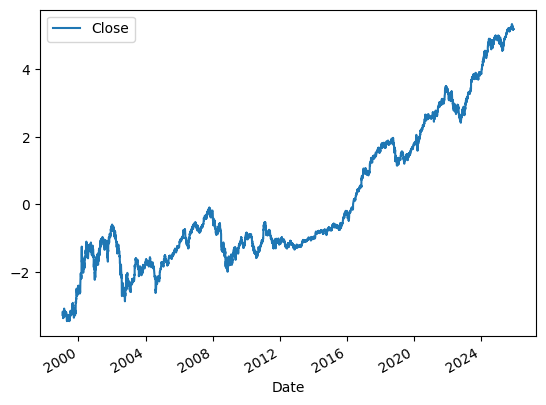

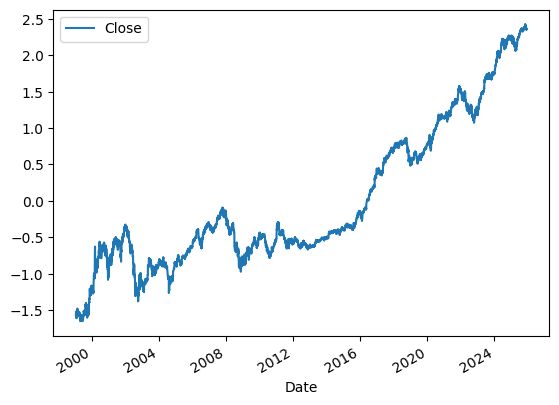

In [10]:
import numpy as np
nv_log = np.log(nvidia_close)
nv_log.plot()
nv = (nv_log - nv_log.mean()) / nv_log.std()
nv.plot()

# Data Splitting and Transforming

In [1]:
from data_handler import (
    extract_stock_close_price,
    log_transformation,
    standardization,
    split_data,
    sliding_window,
    split_feature_targets,
)

file = 'data/nvidia_stock_price_max_hist.csv'
close_raw = extract_stock_close_price("NVDA", "max", file, "Close")

test_ratio = 0.20
train_temp, test_raw = split_data(close_raw, test_ratio)

val_ratio = 0.20
train_raw, val_raw = split_data(train_temp, val_ratio)

train_log = log_transformation(train_raw)
train_clean, train_log_mean, train_log_std = standardization(train_log)

val_log = log_transformation(val_raw)
val_clean = (val_log - train_log_mean) / train_log_std

test_log = log_transformation(test_raw)
test_clean = (test_log - train_log_mean) / train_log_std


In [2]:
window_size = 20
window_step = 2
val_ratio = 0.20

train_set = sliding_window(train_clean, window_size, window_step)
X_train, y_train = split_feature_targets(train_set)

val_set = sliding_window(val_clean, window_size, window_step)
X_val, y_val = split_feature_targets(val_set)

test_set = sliding_window(test_clean, window_size, window_step)
X_test, y_test = split_feature_targets(test_set)

# RNN

In [3]:
from sequence_model import SimpleRNN, train_model
rnn = SimpleRNN()
num_epochs=10
batch_size=32
learning_rate=0.002
rnn_train_loss, rnn_val_loss = train_model(rnn, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val)

Epoch 1
Train loss: 0.8888557131046101
Val Loss: 0.624165976748747
Epoch 2
Train loss: 0.27183185464331044
Val Loss: 0.1403556949842502
Epoch 3
Train loss: 0.11409575917230755
Val Loss: 0.08406390173032004
Epoch 4
Train loss: 0.07287199319633896
Val Loss: 0.05327389857676976
Epoch 5
Train loss: 0.05085854591657955
Val Loss: 0.03608705897760742
Epoch 6
Train loss: 0.03549878423826372
Val Loss: 0.02591348081991515
Epoch 7
Train loss: 0.026329723285658368
Val Loss: 0.01995986528858981
Epoch 8
Train loss: 0.02014258416431189
Val Loss: 0.01609074359978823
Epoch 9
Train loss: 0.015876649243342828
Val Loss: 0.013412361046956742
Epoch 10
Train loss: 0.012698988802131841
Val Loss: 0.011378020308363964


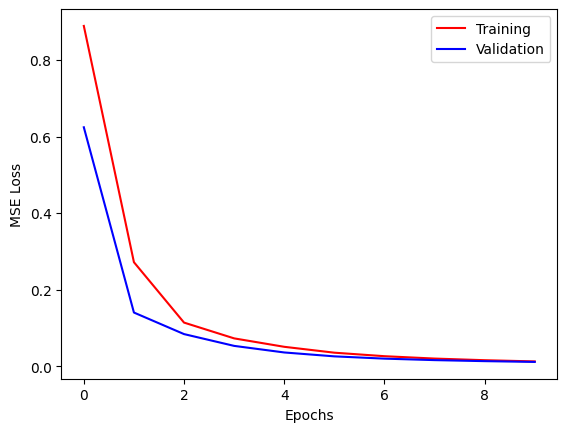

In [4]:
import matplotlib.pyplot as plt
epochs = [*range(num_epochs)]
plt.plot(epochs, rnn_train_loss, label="Training", color="red")
plt.plot(epochs, rnn_val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [5]:
from sequence_model import test_model

rnn_pred = test_model(rnn, X_test, y_test)

In [6]:
from data_handler import inverse_transform

inverse_rnn_pred = inverse_transform(rnn_pred, train_log_mean, train_log_std)
y_true = inverse_transform(y_test, train_log_mean, train_log_std)

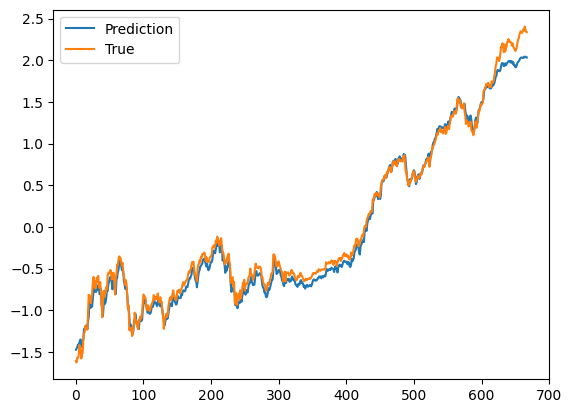

In [7]:
plt.plot(rnn_pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()

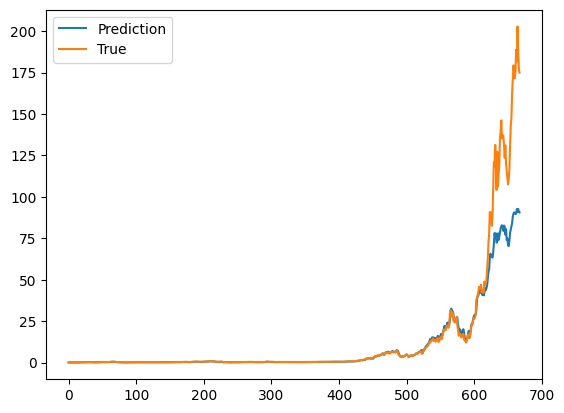

In [8]:
plt.plot(inverse_rnn_pred, label="Prediction")
plt.plot(y_true, label="True")
plt.legend()

In [30]:
import numpy as np
mse = np.mean(np.pow(y_true - inverse_rnn_pred,2))
print(f"MSE: {round(mse,3)}")

rmse = np.sqrt(mse)
print(f"RMSE: {round(rmse,2)}")

mae = np.mean(np.abs(y_true - inverse_rnn_pred))
print(f"MAE: {round(mae,2)}")

MSE: 249.006
RMSE: 15.78
MAE: 4.18


# LSTM

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim
import numpy as np
from numpy.typing import NDArray


class SimpleLSTM(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=8, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=8, out_features=1)

    def forward(self, input):  # x (batch, seq_len, input_size)
        output, (hx, cn) = self.lstm(input)
        y_hat = self.fc(output[:,-1,:])

        return y_hat

In [12]:
from sequence_model import train_model, SimpleLSTM
lstm = SimpleLSTM()
num_epochs=10
batch_size=32
learning_rate=0.002
lstm_train_loss, lstm_val_loss = train_model(lstm, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val)

Epoch 1
Train loss: 1.063222890594796
Val Loss: 0.951510360574021
Epoch 2
Train loss: 0.6126254950187799
Val Loss: 0.43050760282751394
Epoch 3
Train loss: 0.21392734840414693
Val Loss: 0.1665368262294899
Epoch 4
Train loss: 0.1662066067878828
Val Loss: 0.10837790333350901
Epoch 5
Train loss: 0.0749538621851517
Val Loss: 0.054376247284166956
Epoch 6
Train loss: 0.04009168983354945
Val Loss: 0.032415437066982335
Epoch 7
Train loss: 0.03284171653692337
Val Loss: 0.03002539004527909
Epoch 8
Train loss: 0.01882128873223658
Val Loss: 0.010232350691427094
Epoch 9
Train loss: 0.011685207837538602
Val Loss: 0.008325518040424761
Epoch 10
Train loss: 0.00880146256638588
Val Loss: 0.009860663496724823


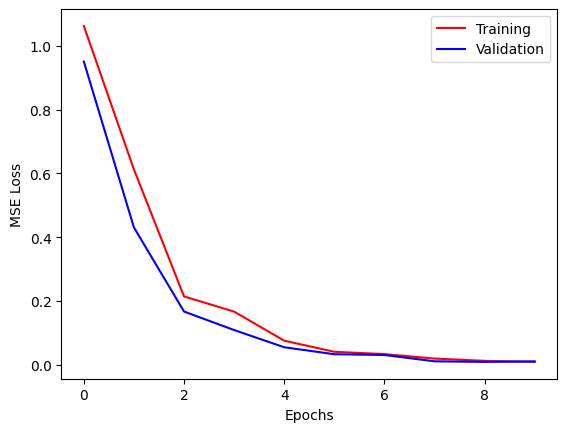

In [13]:
import matplotlib.pyplot as plt
epochs = [*range(num_epochs)]
plt.plot(epochs, lstm_train_loss, label="Training", color="red")
plt.plot(epochs, lstm_val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [14]:
from data_handler import inverse_transform

lstm_pred = test_model(lstm, X_test, y_test)

inverse_lstm_pred = inverse_transform(lstm_pred, train_log_mean, train_log_std)
y_true = inverse_transform(y_test, train_log_mean, train_log_std)

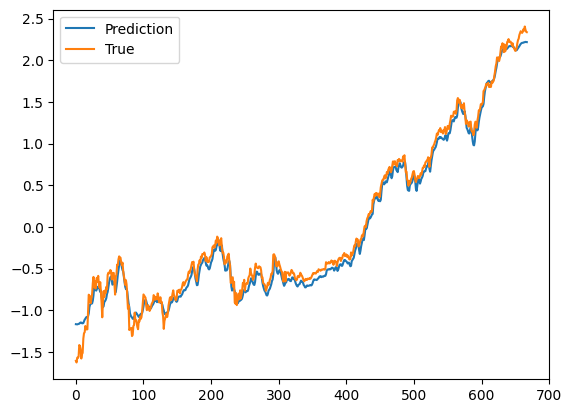

In [15]:
plt.plot(lstm_pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()

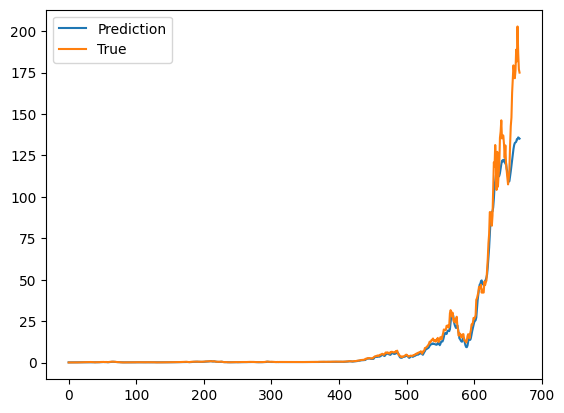

In [16]:
plt.plot(inverse_lstm_pred, label="Prediction")
plt.plot(y_true, label="True")
plt.legend()

In [29]:
mse = np.mean(np.pow(y_true - inverse_lstm_pred,2))
print(f"MSE: {round(mse,3)}")

rmse = np.sqrt(mse)
print(f"RMSE: {round(rmse,2)}")

mae = np.mean(np.abs(y_true - inverse_lstm_pred))
print(f"MAE: {round(mae,2)}")

MSE: 52.92
RMSE: 7.27
MAE: 1.97
